In [2]:
import quantstats as qs
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.colors import LinearSegmentedColormap
from quantstats.stats import *
from quantstats._plotting.wrappers import distribution
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import df2img

# my imports
import sys
sys.path.insert(1, '../scripts')
import utils as utl
import html_evaluation_portfolio as hep
import volatility_estimator as ve

## Functions to compute different volatility estimator

In [3]:
def create_dataframe_high_low(list_securities):
    df = pd.DataFrame()
    for security in list_securities:
        SEC = yf.Ticker(security)
        hist = SEC.history(period="max")
        df[security + '_low'] = hist['Low']
        df[security + '_high'] = hist['High']
        df.dropna(inplace = True) #if this line the data are only from 2010 otyherwise some columns arrive until 2006
    return df

def compute_park_volatility(df_high_low, list_securities, window):
    '''
    input
    df = pandas dataframe with columns named: "security_low" and "security_high" (e.g. SSO_low SSO_high)
    list_securities = list of securities name
    window = int, number of days the index has to consider

    output
    df_output = pandas dataframe with securities as columns and parkinson volat estimator as rows

    '''


    k = np.sqrt(1/(4*window*np.log(2)))
    df_output = pd.DataFrame()

    for security in list_securities:
        #crating array to store the indexes (one per day)
        array_value = np.array([])
        for i in range(len(df_high_low) - window):
            
            #creating array where storing the log((High_price/Low_price)^2)
            array_day_value = np.array([])
            for j in range(window):
                #array_day_value = np.array([])

                #appending the value (one for each window day)
                array_day_value = np.append(array_day_value, np.log((df_high_low[security + '_high'][i+j] / df_high_low[security + '_low'][i+j])**2))
                # len(array_day_value) = window
            square_sum_value = np.sqrt(np.sum(array_day_value))
            array_value = np.append(array_value, k*square_sum_value)

        #dict_security_park_indx[security] = array_value
        df_output[security] = array_value
    return df_output #dict_security_park_indx,

def index_df(df_output, data):
    #just add the index to the dataframe
    data_copy = data.copy()
    data_copy.drop(data_copy.head(window).index, inplace=True) # drop last n rows

    return df_output.set_index(data_copy.index)

def dataframe_strd_dev(data, window):
    df_output = pd.DataFrame()

    list_securities = data.columns
    for security in list_securities:
        #crating array to store the indexes (one per day)
        array_value = np.array([])
        for i in range(len(data) - window): 
            array_value = np.append(array_value, np.std(data[security][i:i+window]))
            
        # assign new array as column of the df
        df_output[security] = array_value
        
    return df_output

def create_dataframe_ohlc(list_securities):
    df = pd.DataFrame()
    for security in list_securities:
        SEC = yf.Ticker(security)
        hist = SEC.history(period="max")
        df[security + '_open'] = hist['Open']
        df[security + '_high'] = hist['High']
        df[security + '_low'] = hist['Low']
        df[security + '_close'] = hist['Close']
        df.dropna(inplace = True) #if this line the data are only from 2010 otyherwise some columns arrive until 2006
    return df

def compute_satchell_volatility(df_ohlc, list_securities, window):
    '''write descreiption'''

    df_output = pd.DataFrame()

    for security in list_securities:
        #crating array to store the indexes (one per day)
        array_value = np.array([])
        for i in range(len(df_ohlc) - window):
            
            #creating array where storing the log((High_price/Low_price)^2)
            array_day_value = np.array([])
            for j in range(window):
                #array_day_value = np.array([])

                #appending the value (one for each window day)
                array_day_value = np.append(array_day_value, np.log((df_ohlc[security + '_high'][i+j] / df_ohlc[security + '_close'][i+j]))*np.log((df_ohlc[security + '_high'][i+j] / df_ohlc[security + '_open'][i+j]))
                                                            + np.log((df_ohlc[security + '_low'][i+j] / df_ohlc[security + '_close'][i+j]))*np.log((df_ohlc[security + '_low'][i+j] / df_ohlc[security + '_open'][i+j])))
                # len(array_day_value) = window
            square_sum_value = np.sqrt((1/window)*np.sum(array_day_value))
            array_value = np.append(array_value,square_sum_value)

        #dict_security_park_indx[security] = array_value
        df_output[security] = array_value
    return df_output #dict_security_park_indx,


## Main

I use the functions create above to study the correlation between the indexes

In [17]:
list_securities = ['VTI', 'VGLT', 'VGIT', 'IAU', 'PDBC'] #['SSO', 'UBT', 'UST', 'UPW', 'UGL']
window = 30 #days

In [18]:
data_h_l = create_dataframe_high_low(list_securities)
data_h_l = data_h_l[-1834:]
df_park_volat = compute_park_volatility(data_h_l, list_securities, window)
data = hep.create_dataframe(list_securities)
data = data[-1834:]
#data.dropna(inplace = True)
df_park_volat = index_df(df_park_volat, data)

In [19]:
df_strd_dev =  dataframe_strd_dev(data, 30)
df_strd_dev = index_df(df_strd_dev, data)

In [7]:
data_ohlc = create_dataframe_ohlc(list_securities)
data_ohlc = data_ohlc[-1834:]
df_satchell_volat = compute_satchell_volatility(data_ohlc, list_securities, window)

df_satchell_volat = index_df(df_satchell_volat, data)
df_satchell_volat
# it takes few seconds to compile

,VTI,VGLT,VGIT,IAU,PDBC
Date,,,,,
2015-02-25,0.007877,0.006060,0.002415,0.007196,0.003191
2015-02-26,0.007790,0.006076,0.002480,0.007155,0.003127
2015-02-27,0.007264,0.006006,0.002456,0.007077,0.003127
2015-03-02,0.007123,0.006088,0.002376,0.007064,0.002722
2015-03-03,0.007035,0.006061,0.002442,0.006888,0.002692
...,...,...,...,...,...
2022-04-18,0.009854,0.007605,0.002305,0.008516,0.017148
2022-04-19,0.009746,0.007588,0.002268,0.008396,0.016802
2022-04-20,0.009747,0.007419,0.002251,0.008421,0.016566


In [8]:
df_volat_SSO = pd.DataFrame()
df_volat_SSO['Stv'] = df_strd_dev['SSO']
df_volat_SSO['Park'] = df_park_volat['SSO']
df_volat_SSO['Satch'] = df_satchell_volat['SSO']

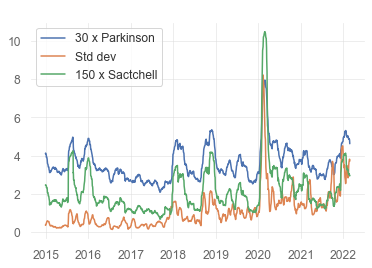

In [9]:
plt.plot(df_volat_SSO['Park']*30, label = '30 x Parkinson')
plt.plot(df_volat_SSO['Stv'], label = 'Std dev')
plt.plot(df_volat_SSO['Satch']*150, label = '150 x Sactchell')
plt.title('Volatility estimator comparison (SSO)', color = 'w')

plt.legend()
plt.savefig('../img/voltility_estimator_comparasion.png')
plt.show()


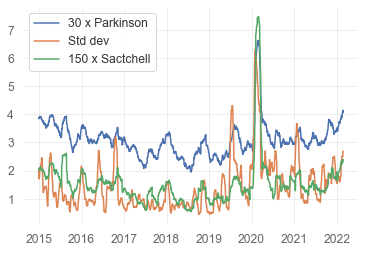

In [12]:
df_volat_UBT = pd.DataFrame()
df_volat_UBT['Stv'] = df_strd_dev['UBT']
df_volat_UBT['Park'] = df_park_volat['UBT']
df_volat_UBT['Satch'] = df_satchell_volat['UBT']
plt.plot(df_volat_UBT['Park']*30, label = '30 x Parkinson')
plt.plot(df_volat_UBT['Stv'], label = 'Std dev')
plt.plot(df_volat_UBT['Satch']*150, label = '150 x Sactchell')

plt.legend()
plt.show()

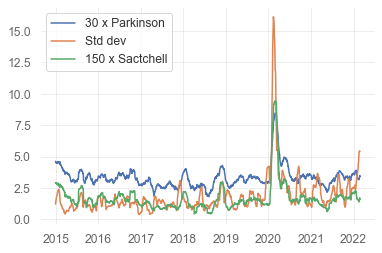

In [15]:
df_volat_UPW = pd.DataFrame()
df_volat_UPW['Stv'] = df_strd_dev['UPW']
df_volat_UPW['Park'] = df_park_volat['UPW']
df_volat_UPW['Satch'] = df_satchell_volat['UPW']
plt.plot(df_volat_UPW['Park']*30, label = '30 x Parkinson')
plt.plot(df_volat_UPW['Stv'], label = 'Std dev')
plt.plot(df_volat_UPW['Satch']*150, label = '150 x Sactchell')

plt.legend()
plt.show()

In [18]:
df_volat_UGL = pd.DataFrame()
df_volat_UGL['Stv'] = df_strd_dev['UGL']
df_volat_UGL['Park'] = df_park_volat['UGL']
df_volat_UGL['Satch'] = df_satchell_volat['UGL']

            Stv      Park     Satch
Stv    1.000000  0.689900  0.732923
Park   0.689900  1.000000  0.951848
Satch  0.732923  0.951848  1.000000


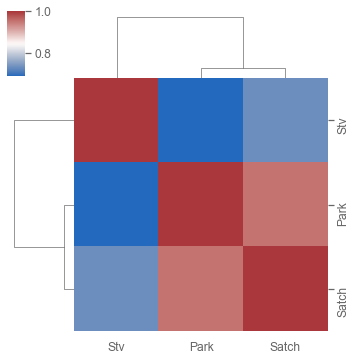

In [25]:
corr = df_volat_SSO.corr()
print(corr)

fig = sns.clustermap(corr, figsize=(5,5), cmap='vlag')
#fig.title('Correlation between estimators', color ='w')
fig.savefig('../img/voltility_estimator_correlation.png') 

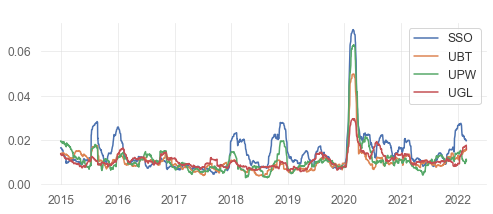

In [40]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(3)
plt.plot(df_volat_SSO['Satch'], label = 'SSO')
plt.plot(df_volat_UBT['Satch'], label = 'UBT')
plt.plot(df_volat_UPW['Satch'], label = 'UPW')
plt.plot(df_volat_UGL['Satch'], label = 'UGL')

plt.legend()
plt.title('Sathcell index for the x2 leverage portfolio', color = 'w')
plt.savefig('../img/satch_x2_leverage_voltility_estimator_comparasion.png')

plt.show()

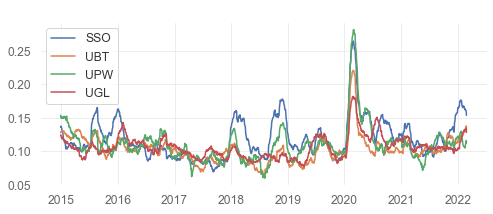

In [41]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(3)
plt.plot(df_volat_SSO['Park'], label = 'SSO')
plt.plot(df_volat_UBT['Park'], label = 'UBT')
plt.plot(df_volat_UPW['Park'], label = 'UPW')
plt.plot(df_volat_UGL['Park'], label = 'UGL')

plt.legend()
plt.title('Parkinson index for the x2 leverage portfolio', color = 'w')
plt.savefig('../img/park_x2_leverage_voltility_estimator_comparasion.png')

plt.show()

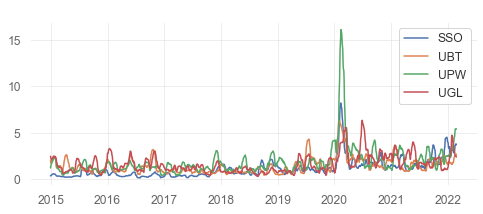

In [42]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(3)
plt.plot(df_volat_SSO['Stv'], label = 'SSO')
plt.plot(df_volat_UBT['Stv'], label = 'UBT')
plt.plot(df_volat_UPW['Stv'], label = 'UPW')
plt.plot(df_volat_UGL['Stv'], label = 'UGL')

plt.legend()
plt.title('Standard deviation for the x2 leverage portfolio', color = 'w')
plt.savefig('../img/stdv_x2_leverage_voltility_estimator_comparasion.png')

plt.show()

In [20]:
df_strd_dev

,VTI,VGLT,VGIT,IAU,PDBC
Date,,,,,
2015-02-25,1.750888,1.537609,0.359332,0.634155,0.231869
2015-02-26,1.814153,1.544727,0.359936,0.651042,0.230164
2015-02-27,1.854511,1.571286,0.365028,0.663641,0.226011
2015-03-02,1.847692,1.581262,0.365986,0.673165,0.229211
2015-03-03,1.799324,1.606320,0.357375,0.688646,0.221831
...,...,...,...,...,...
2022-04-18,6.698961,2.699318,1.047424,0.583211,0.609111
2022-04-19,6.647561,2.699694,0.992449,0.587677,0.651609
2022-04-20,6.289976,2.731839,0.953523,0.565376,0.652430


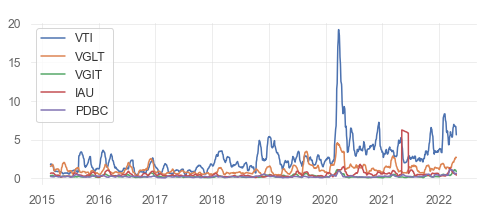

In [21]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(3)
plt.plot(df_strd_dev['VTI'], label = 'VTI')
plt.plot(df_strd_dev['VGLT'], label = 'VGLT')
plt.plot(df_strd_dev['VGIT'], label = 'VGIT')
plt.plot(df_strd_dev['IAU'], label = 'IAU')
plt.plot(df_strd_dev['PDBC'], label = 'PDBC')


plt.legend()
plt.title('Standard deviation for the x1 leverage portfolio', color = 'w')
plt.savefig('../img/stdv_x1_leverage_voltility_estimator_comparasion.png')

plt.show()

## Compute the plot above fro the 2007-2012 period

In [8]:
start_date = pd.to_datetime('2007-01-03') 
end_date = pd.to_datetime(start_date) + pd.DateOffset(days=1814) 
window = 30
list_securities = ['SPY', 'TLT', 'GLD']

In [9]:
data = hep.create_dataframe(list_securities)
data = data[start_date: end_date]

df_strd_dev =  dataframe_strd_dev(data, window)
df_strd_dev = index_df(df_strd_dev, data)

data_h_l = create_dataframe_high_low(list_securities)
data_h_l = data_h_l[start_date: end_date]
df_park_volat = compute_park_volatility(data_h_l, list_securities, window)
df_park_volat = index_df(df_park_volat, data)

data_ohlc = create_dataframe_ohlc(list_securities)
data_ohlc = data_ohlc[start_date: end_date]
df_satchell_volat = compute_satchell_volatility(data_ohlc, list_securities, window)
df_satchell_volat = index_df(df_satchell_volat, data)

In [10]:
df_volat_SPY = pd.DataFrame()
df_volat_SPY['Stv'] = df_strd_dev['SPY']
df_volat_SPY['Park'] = df_park_volat['SPY']
df_volat_SPY['Satch'] = df_satchell_volat['SPY']

df_volat_TLT = pd.DataFrame()
df_volat_TLT['Stv'] = df_strd_dev['TLT']
df_volat_TLT['Park'] = df_park_volat['TLT']
df_volat_TLT['Satch'] = df_satchell_volat['TLT']

df_volat_GLD = pd.DataFrame()
df_volat_GLD['Stv'] = df_strd_dev['GLD']
df_volat_GLD['Park'] = df_park_volat['GLD']
df_volat_GLD['Satch'] = df_satchell_volat['GLD']

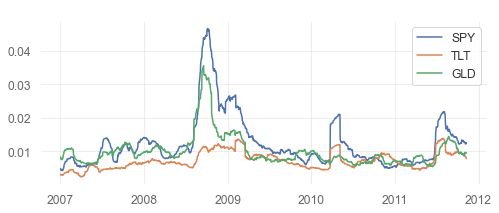

In [15]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(3)
plt.plot(df_volat_SPY['Satch'], label = 'SPY')
plt.plot(df_volat_TLT['Satch'], label = 'TLT')
plt.plot(df_volat_GLD['Satch'], label = 'GLD')

plt.legend()
plt.title('Sathcell index for the all weather', color = 'w')
plt.savefig('../img/satch_potrfolio_2008_comparasion.png')

plt.show()

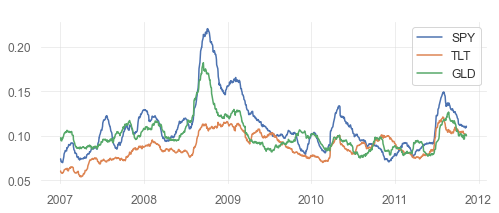

In [13]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(3)
plt.plot(df_volat_SPY['Park'], label = 'SPY')
plt.plot(df_volat_TLT['Park'], label = 'TLT')
plt.plot(df_volat_GLD['Park'], label = 'GLD')

plt.legend()
plt.title('Parkinson index for the all weather', color = 'w')
plt.savefig('../img/park_2008_potrfolio_comparasion.png')

plt.show()

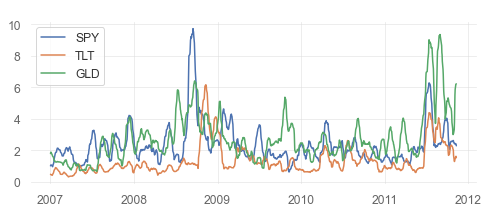

In [14]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(3)
plt.plot(df_volat_SPY['Stv'], label = 'SPY')
plt.plot(df_volat_TLT['Stv'], label = 'TLT')
plt.plot(df_volat_GLD['Stv'], label = 'GLD')

plt.legend()
plt.title('Standard deviation index for the all weather', color = 'w')
plt.savefig('../img/stdv_2008_potrfolio_comparasion.png')

plt.show()